Plot trained KAN and set linear function on input activations (and fine-tune)

In [1]:
# Choose dataset to plot/symbolic fitting
# ASCADf | ASCADv
ds = 'ASCADf'

----- Program codes ----

In [2]:
import torch
from pathlib import Path
import os
import hydra
import numpy as np
import matplotlib.pyplot as plt
import pickle

os.chdir('/workspace')
import src

In [3]:
if ds == 'ASCADf':
    pt = "[[156, 157, 1],[517, 518, 1]]"
elif ds == 'ASCADv':
    pt = "[[188, 189, 1],[1071, 1072, 1]]"

In [4]:
with hydra.initialize(config_path="../../conf", version_base='1.1'):
    cfg = hydra.compose(
        config_name='config',
        overrides=[
            "model=KAN1h",
            "model.model.width.1=1",
            "model.model.grid=3",
            "model.model.k=3",
            "model.train_params.steps=3000",
            f"dataset@train={ds}_profiling",
            f"dataset@test={ds}_attack",
            "trace_transforms=set_poi",
            f"trace_transforms.transforms.0.pois={pt}",
            "trace_transforms.output_size=2",
            "label_transforms=bit",
            "label_transforms.transforms.3.pos=0",
            f"save_path=/workspace/results/ascad/KAN_{ds}_snr/0",
            "n_attack_traces=2000"
            ]
        )

In [5]:
device = hydra.utils.instantiate(cfg.device)
cpu = torch.device('cpu')

Setup dataset

In [6]:
profiling_dataset = hydra.utils.instantiate(cfg.train.dataset)
test_dataset = hydra.utils.instantiate(cfg.test.dataset)

train_dataloader = torch.utils.data.DataLoader(
    profiling_dataset, batch_size=cfg.train.batch_size, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=cfg.test.batch_size, shuffle=False
)
KANds = src.utils.to_KAN_dataset(
    train_dataloader, test_dataloader,
    device=device)

Train KAN

In [7]:
model = hydra.utils.instantiate(cfg.model.model)
model.load_ckpt(cfg.model_name+'.ckpt', cfg.save_path)
model = model.to(device)

Evaluation

In [8]:
preds, labels, th = src.utils.make_prediction(
    model, test_dataloader, device)
preds_class = np.argmax(preds, axis=1)
accuracy = np.mean(labels == preds_class)
print('Accuracy: ', accuracy)

Accuracy:  0.568


Plot trained KAN

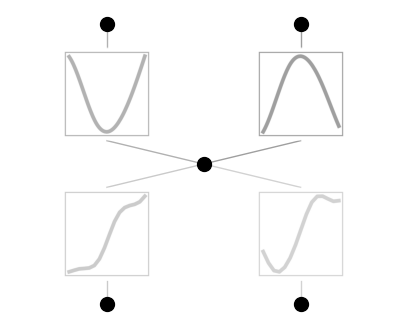

In [9]:
model(KANds['train_input'][:10000])
model.plot(folder=cfg.save_path+'/raw')
plt.savefig(
    Path(cfg.save_path, f'{cfg.model.name}_raw.png'),
    dpi=300, bbox_inches=0)
src.utils.plot_KAN(cfg, model, 'raw')

Set symbolic functions

In [10]:
model(KANds['test_input'][:10000])
model.fix_symbolic(0,0,0, 'x')
model.fix_symbolic(0,1,0, 'x')

r2 is 0.9459356665611267
r2 is 0.938764750957489


tensor(0.9388, device='cuda:0')

Fine-tuning

In [11]:
_ = model.train(
    KANds,
    **hydra.utils.instantiate(cfg.model.train_params)
    )

train loss: 8.26e-01 | test loss: 8.29e-01 | reg: 4.59e-01 : 100%|█| 3000/3000 [01:41<00:00, 29.41it


Evaluate

In [12]:
preds, labels, th = src.utils.make_prediction(
    model, test_dataloader, device)

preds_class = np.argmax(preds, axis=1)
accuracy = np.mean(labels == preds_class)
print('Accuracy: ', accuracy)

Accuracy:  0.5586


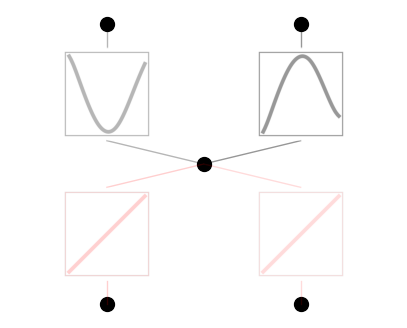

In [13]:
model(KANds['train_input'][:10000])
model.plot(folder=cfg.save_path+'/fixed')
plt.savefig(
    Path(cfg.save_path, f'{cfg.model.name}_fixed.png'),
    dpi=300, bbox_inches='tight')
src.utils.plot_KAN(cfg, model, 'fixed')

In [14]:
correct_key = test_dataset.key[0][cfg.target_byte]
key_hyposesis = range(256)
if not Path(cfg.save_path, 'label_hyposesis.npy').exists():
    label_hyposesis = src.utils.make_label_hyposesis(
        test_dataset, key_hyposesis)
    np.save(Path(cfg.save_path, 'label_hyposesis.npy'), label_hyposesis)
label_hyposesis = np.load(Path(cfg.save_path, 'label_hyposesis.npy'))

ge = src.sca_utils.calc_guessing_entropy(
    preds, label_hyposesis, correct_key,
    cfg.n_attack_traces, n_trial=cfg.n_trials)
print(np.where(ge==0)[0])

Calculating GE [/trials]: 100%|██████████| 40/40 [00:01<00:00, 27.88it/s]

[ 803  804  805 ... 1997 1998 1999]


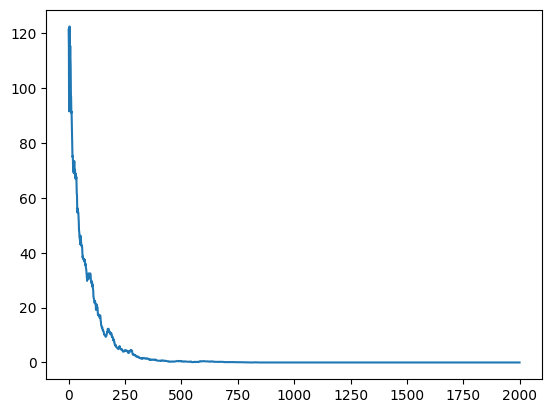

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ge)
fig.savefig(Path(cfg.save_path, f'{cfg.model.name}_fixed.png'), dpi=300, bbox_inches='tight')